<div style = "text-align:center">
    <h1>Housing Forecast</h1>
</div>

Notes:
- Predict the prices of houses that haven't been sold yet.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploring and cleaning the data

This section here is exploratory data analysis. We want to understand the data before we manipulate anything. Data cleaning. 

In [4]:
#Show the first 6 rows.
test.head()

,id,zipcode,city,state,dateSold,bathrooms,bedrooms,livingArea,homeType,homeStatus,lotArea,lotUnit,address
0,22805,19970.0,Ocean View,DE,1.641283e+12,4.0,5.0,4100.0,SINGLE_FAMILY,RECENTLY_SOLD,10454.40,sqft,"37150 Lord Baltimore Ln, Ocean View, DE 19970"
1,18392,27704.0,Durham,NC,1.641542e+12,3.0,4.0,2055.0,SINGLE_FAMILY,RECENTLY_SOLD,0.29,acres,"2011 Woodview Dr, Durham, NC 27704"
2,15215,20733.0,Churchton,MD,1.641542e+12,2.0,3.0,1530.0,SINGLE_FAMILY,RECENTLY_SOLD,4791.60,sqft,"1109 Wildwood Ln, Churchton, MD 20733"
3,20235,33064.0,Pompano Beach,FL,1.641370e+12,1.0,3.0,744.0,SINGLE_FAMILY,RECENTLY_SOLD,6120.00,sqft,"3130 NE 12th Ave, Pompano Beach, FL 33064"
4,13810,6239.0,Killingly,CT,1.640851e+12,3.0,6.0,4166.0,SINGLE_FAMILY,RECENTLY_SOLD,37.00,sqft,"235 Ross Rd, Killingly, CT 06239"


In [7]:
#List the columns in our data
train.columns

Index(['id', 'zipcode', 'city', 'state', 'dateSold', 'bathrooms', 'bedrooms',
       'livingArea', 'homeType', 'homeStatus', 'lotArea', 'lotUnit', 'address',
       'price'],
      dtype='object')

Now we can see the top 5 most common values in each column.

In [11]:
for column in train.columns:
    print(column)
    #value_counts counts how times something appears many and n largest gets the top 5 largest values.
    print(train[column].value_counts().nlargest(5))
    print()

id
20479    1
7329     1
18029    1
18414    1
8249     1
Name: id, dtype: int64

zipcode
82001.0    103
82009.0     68
99504.0     62
99577.0     60
83709.0     56
Name: zipcode, dtype: int64

city
Anchorage       318
Louisville      224
Cheyenne        205
Las Vegas       199
Indianapolis    198
Name: city, dtype: int64

state
CT    938
IN    885
GA    862
DE    845
IA    832
Name: state, dtype: int64

dateSold
1.640851e+12    4724
1.641542e+12    3566
1.641456e+12    2444
1.641370e+12    1870
1.640765e+12    1735
Name: dateSold, dtype: int64

bathrooms
2.0    10563
3.0     6628
1.0     4018
4.0     1643
5.0      294
Name: bathrooms, dtype: int64

bedrooms
3.0    11286
4.0     5751
2.0     4161
5.0     1309
1.0      630
Name: bedrooms, dtype: int64

livingArea
1200.000000    150
1954.681419    117
1800.000000    107
960.000000      96
1400.000000     95
Name: livingArea, dtype: int64

homeType
SINGLE_FAMILY    19067
CONDO             2117
TOWNHOUSE         1922
MULTI_FAMILY       528

Important things to note:
- State, city, # of bedrooms and bathrooms, living area, and home type will probably be the most important categories to include.

- Deal with zipcode later (edit this later).
- Date sold might not be helpful here. These houses should be sold around the same time.
- Some houses haven't even been sold yet. This can skew the data.
- Only 4 types of homes.
- 0 lot area for condos and townhouses. 
- Some of the loat area is measured in sqft while others are measured in acres. 
- The address is too specific.

First we will get rid of the houses that haven't been sold yet. 

In [14]:
#Make a copy of the original data but exclude unsold houses.

train_only_sold = train[train['homeStatus'] == 'RECENTLY_SOLD'].copy()

#Now drop home status column. This column is unnecessary.
#Note: axis = 1 is for columns. axis = 0 is for rows.
train_only_sold = train_only_sold.drop('homeStatus', axis = 1)
train_only_sold.head()

,id,zipcode,city,state,dateSold,bathrooms,bedrooms,livingArea,homeType,lotArea,lotUnit,address,price
0,20479,76247.0,Justin,TX,1.641456e+12,3.0,4.0,3078.0,SINGLE_FAMILY,7492.32,sqft,"1937 Caddo Springs Dr, Justin, TX 76247",358100.0
2,9816,85340.0,Litchfield Park,AZ,1.641370e+12,5.0,5.0,3722.0,SINGLE_FAMILY,6577.56,sqft,"14584 W Hidden Terrace Loop, Litchfield Park, ...",660000.0
3,4479,99507.0,Anchorage,AK,1.641370e+12,2.0,3.0,1388.0,CONDO,0.00,sqft,"2903 Suncatcher Ct, Anchorage, AK 99507",232500.0
4,180,3901.0,Berwick,ME,1.640905e+12,4.0,3.0,2972.0,SINGLE_FAMILY,1.83,acres,"32 Tyler Ln, Berwick, ME 03901",551900.0
5,21279,80241.0,Thornton,CO,1.640851e+12,3.0,2.0,1926.0,TOWNHOUSE,0.00,sqft,"1284 E 130th Ave UNIT A, Thornton, CO 80241",435000.0


Nest we double check the date sold column. If these dates are close enough, then it won't be necessary to include a timeline.

(array([ 120.,   32.,  226.,   79.,  387., 1044., 1618., 1498., 8309.,
        9835.]),
 array([1.6373088e+12, 1.6377408e+12, 1.6381728e+12, 1.6386048e+12,
        1.6390368e+12, 1.6394688e+12, 1.6399008e+12, 1.6403328e+12,
        1.6407648e+12, 1.6411968e+12, 1.6416288e+12]),
 <BarContainer object of 10 artists>)

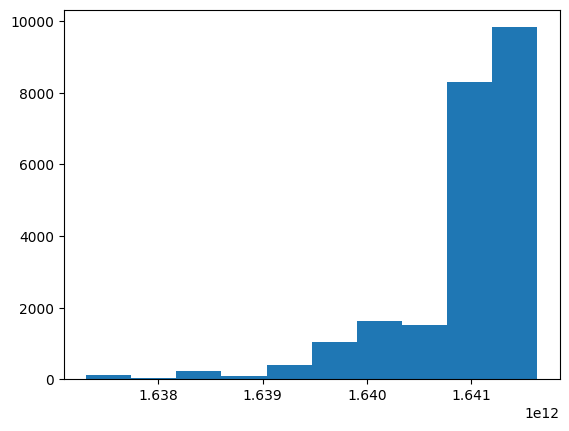

In [15]:
plt.hist(train_only_sold['dateSold'])

From this histogram, we can see that these houses were sold around the same time. Therefore, the date won't effect the prices of the houses. We can drop this column as well. 

In [16]:
#Create another copy of the data.

train_without_date = train_only_sold.drop('dateSold', axis = 1)

train_without_date.head()

,id,zipcode,city,state,bathrooms,bedrooms,livingArea,homeType,lotArea,lotUnit,address,price
0,20479,76247.0,Justin,TX,3.0,4.0,3078.0,SINGLE_FAMILY,7492.32,sqft,"1937 Caddo Springs Dr, Justin, TX 76247",358100.0
2,9816,85340.0,Litchfield Park,AZ,5.0,5.0,3722.0,SINGLE_FAMILY,6577.56,sqft,"14584 W Hidden Terrace Loop, Litchfield Park, ...",660000.0
3,4479,99507.0,Anchorage,AK,2.0,3.0,1388.0,CONDO,0.00,sqft,"2903 Suncatcher Ct, Anchorage, AK 99507",232500.0
4,180,3901.0,Berwick,ME,4.0,3.0,2972.0,SINGLE_FAMILY,1.83,acres,"32 Tyler Ln, Berwick, ME 03901",551900.0
5,21279,80241.0,Thornton,CO,3.0,2.0,1926.0,TOWNHOUSE,0.00,sqft,"1284 E 130th Ave UNIT A, Thornton, CO 80241",435000.0


Since the address is too specific, we will also drop this column as well. 

In [17]:
train_without_address = train_without_date.drop('address', axis = 1)

train_without_address.head()

,id,zipcode,city,state,bathrooms,bedrooms,livingArea,homeType,lotArea,lotUnit,price
0,20479,76247.0,Justin,TX,3.0,4.0,3078.0,SINGLE_FAMILY,7492.32,sqft,358100.0
2,9816,85340.0,Litchfield Park,AZ,5.0,5.0,3722.0,SINGLE_FAMILY,6577.56,sqft,660000.0
3,4479,99507.0,Anchorage,AK,2.0,3.0,1388.0,CONDO,0.00,sqft,232500.0
4,180,3901.0,Berwick,ME,4.0,3.0,2972.0,SINGLE_FAMILY,1.83,acres,551900.0
5,21279,80241.0,Thornton,CO,3.0,2.0,1926.0,TOWNHOUSE,0.00,sqft,435000.0


To clean up the data further, we can drop the id too.

In [18]:
train_without_id = train_without_address.drop('id', axis=1)

train_without_id.head()

,zipcode,city,state,bathrooms,bedrooms,livingArea,homeType,lotArea,lotUnit,price
0,76247.0,Justin,TX,3.0,4.0,3078.0,SINGLE_FAMILY,7492.32,sqft,358100.0
2,85340.0,Litchfield Park,AZ,5.0,5.0,3722.0,SINGLE_FAMILY,6577.56,sqft,660000.0
3,99507.0,Anchorage,AK,2.0,3.0,1388.0,CONDO,0.00,sqft,232500.0
4,3901.0,Berwick,ME,4.0,3.0,2972.0,SINGLE_FAMILY,1.83,acres,551900.0
5,80241.0,Thornton,CO,3.0,2.0,1926.0,TOWNHOUSE,0.00,sqft,435000.0


After getting rid of the unnecessary columns, we can graph all of the numerical columns and look at the distribution of the data. 

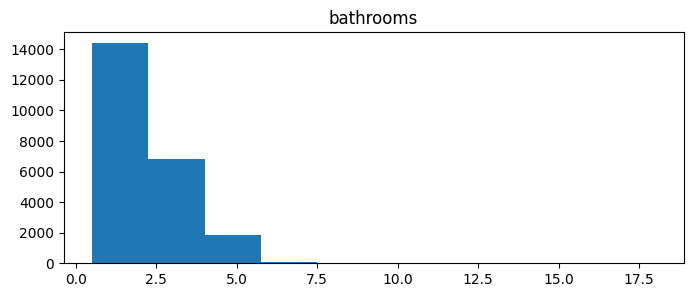

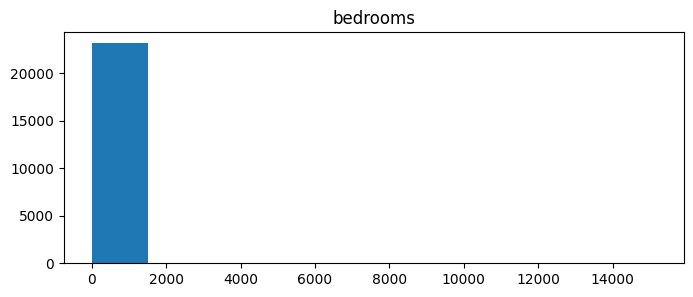

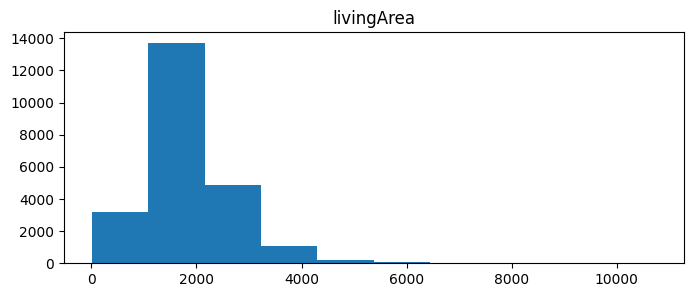

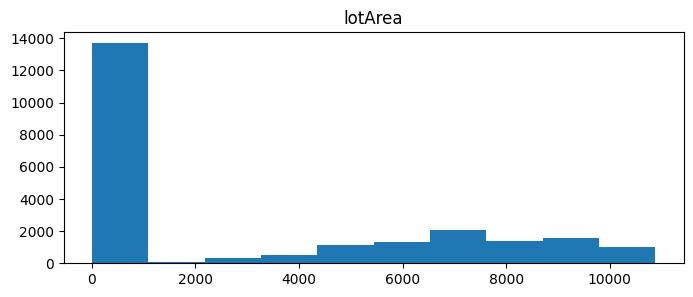

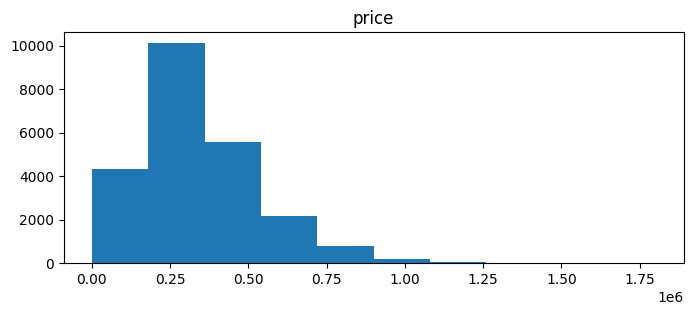

In [19]:
numerical_variables = ['bathrooms', 'bedrooms', 'livingArea', 'lotArea', 'price']


for variable in numerical_variables:
    plt.figure(figsize=(8,3))
    plt.title(variable)
    plt.hist(train_without_id[variable])
    plt.show()

A lot of these graphs are skewed.
- For bathrooms, there seems to be a house with 18 bathrooms. 
- There also seems to be a house with a huge amount of bedrooms. 
- The lot area histogram has quite a few conflicting data. Condos and townhouses don't have any lot area and there are 2 different measurements (sqft and acres). 

Before we deal with the outliers, we have to convert the lot area measurements. Each acre is 43,560 sqft.

In [20]:
#This function will convert acres to sqft. 
def convert_lot_area(row):
    if row['lotUnit'] == 'acres':
        return row['lotArea'] * 43560
    else:
        return row['lotArea']

#Use .apply() to apply the function to the lot area column in the dataframe.  
train_without_id['lotArea'] = train_without_id.apply(convert_lot_area, axis=1)
#Afterwards, drop the lot unit since everything is in sqft.
train_without_id = train_without_id.drop('lotUnit', axis=1)
train_without_id.head()

,zipcode,city,state,bathrooms,bedrooms,livingArea,homeType,lotArea,price
0,76247.0,Justin,TX,3.0,4.0,3078.0,SINGLE_FAMILY,7492.32,358100.0
2,85340.0,Litchfield Park,AZ,5.0,5.0,3722.0,SINGLE_FAMILY,6577.56,660000.0
3,99507.0,Anchorage,AK,2.0,3.0,1388.0,CONDO,0.00,232500.0
4,3901.0,Berwick,ME,4.0,3.0,2972.0,SINGLE_FAMILY,79714.80,551900.0
5,80241.0,Thornton,CO,3.0,2.0,1926.0,TOWNHOUSE,0.00,435000.0


(array([20525.,  1294.,   502.,   236.,   175.,   205.,    94.,    46.,
           37.,    34.]),
 array([     0.  ,  43429.32,  86858.64, 130287.96, 173717.28, 217146.6 ,
        260575.92, 304005.24, 347434.56, 390863.88, 434293.2 ]),
 <BarContainer object of 10 artists>)

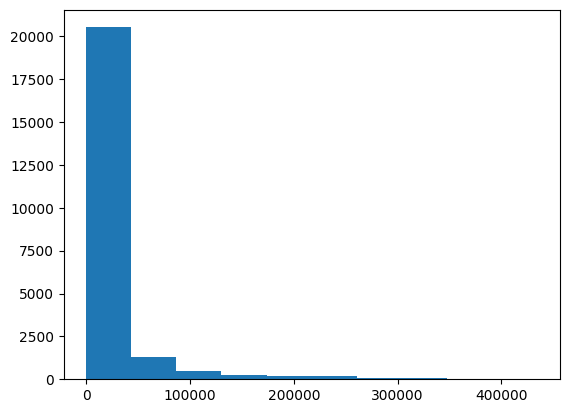

In [21]:
plt.hist(train_without_id['lotArea'])

Even after converting the measurements, the data is still skewed. 

# Statistical Data Analysis
Now we have to deal with the outliers so that the ML algorithm will be more accurate. 

In [36]:
train_without_id['bedrooms'] .value_counts()

3.000000        11044
4.000000         5636
2.000000         4095
5.000000         1269
1.000000          612
6.000000          244
3.729905          176
7.000000           34
8.000000           18
9.000000            8
10.000000           5
14.000000           2
12.000000           2
15153.000000        1
33.000000           1
30.000000           1
Name: bedrooms, dtype: int64

We can see now that there is a house with 15,153 bedrooms! The rest of our houses have no where near that many bedrooms. So we will find the mean and calculate 2 standard deviations from the mean and exclude the houses with the number of bedrooms that are outside of this range. 

In [26]:
train_without_id['bedrooms']

0        4.0
2        5.0
3        3.0
4        3.0
5        2.0
        ... 
23628    3.0
23629    3.0
23631    3.0
23632    2.0
23633    2.0
Name: bedrooms, Length: 23148, dtype: float64

In [27]:
train_without_id['bedrooms'].mean()

3.8325325440792666

In [30]:
#Calculate if a house has more or less the amount of bedrooms from the average.
distance_from_mean = np.abs(train_without_id['bedrooms'] - train_without_id['bedrooms'].mean())

distance_from_mean

0        0.167467
2        1.167467
3        0.832533
4        0.832533
5        1.832533
           ...   
23628    0.832533
23629    0.832533
23631    0.832533
23632    1.832533
23633    1.832533
Name: bedrooms, Length: 23148, dtype: float64

In [40]:
#Calculate the # of bedrooms that is 2 standard deviations from the mean.
std_x_3 = train_without_id['bedrooms'].std() * 2

std_x_3

199.1599243007334

We now drop all of the data points outside of this range.

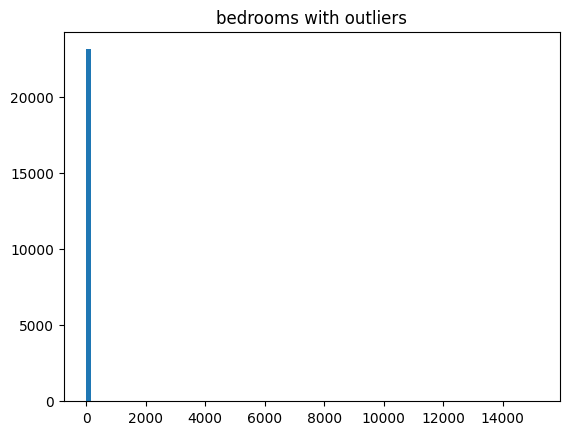

(array([6.1200e+02, 0.0000e+00, 0.0000e+00, 4.0950e+03, 0.0000e+00,
        0.0000e+00, 1.1044e+04, 0.0000e+00, 1.7600e+02, 5.6360e+03,
        0.0000e+00, 0.0000e+00, 1.2690e+03, 0.0000e+00, 0.0000e+00,
        2.4400e+02, 0.0000e+00, 0.0000e+00, 3.4000e+01, 0.0000e+00,
        0.0000e+00, 1.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

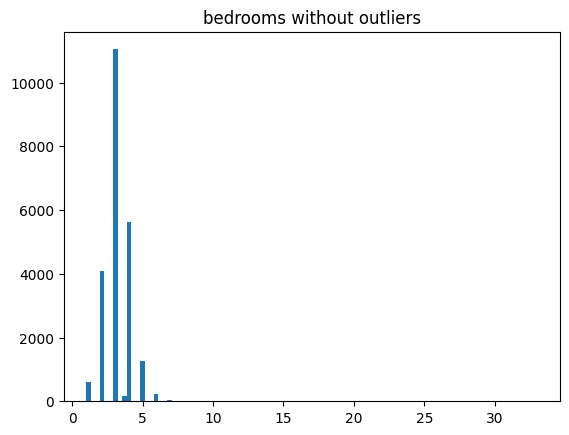

In [41]:
bedrooms_wihtout_outliers = train_without_id[distance_from_mean < std_x_3]['bedrooms']

plt.title('bedrooms with outliers')
plt.hist(train_without_id['bedrooms'], bins=100)
plt.show()

plt.title('bedrooms without outliers')
plt.hist(bedrooms_wihtout_outliers, bins=100)

Playing with Functions.

In [6]:
#Testing recursion
#Should return the nth fibonacci number (1, 1, 2, 3, 5, 8, 13, etc)
def fibonacci(n):
    if n == 1 or n == 0:
        return 1
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)


In [9]:
fibonacci(20)

10946

Playing with some plotting.

In [15]:
#Playing with plotting

x = np.random.normal(size=100)
y = np.random.normal(size=100)

xp = np.random.normal(loc=2, scale=1.5, size=100)
yp = np.random.normal(loc=2, size=100)

(array([ 1.,  3., 11., 15., 20., 23., 11.,  9.,  5.,  2.]),
 array([-2.70137457, -2.14594308, -1.5905116 , -1.03508011, -0.47964863,
         0.07578285,  0.63121434,  1.18664582,  1.74207731,  2.29750879,
         2.85294028]),
 <BarContainer object of 10 artists>)

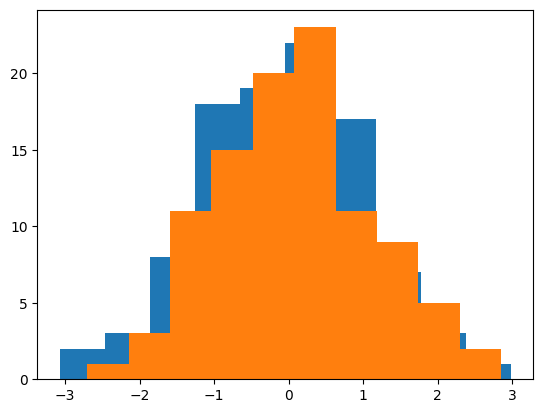

In [13]:
plt.hist(x)
plt.hist(y)

Text(0.5, 0, 'X axis')

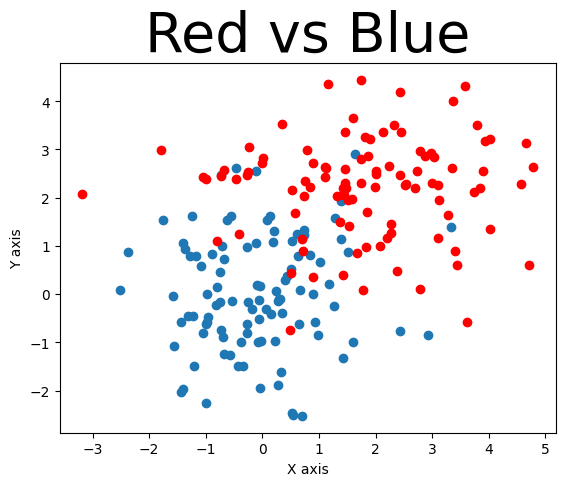

In [23]:
plt.scatter(x,y)
plt.scatter(xp, yp, c= 'red')
plt.title('Red vs Blue', fontdict={'size':40})
plt.ylabel('Y axis')
plt.xlabel('X axis')